In [2]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


In [155]:
pTrainData_fibrePrediction = 'train_prediction_grid_normalized.h5'
pTrainData_fibreTracking = 'train_tracking_grid_normalized.h5'
pTrainInput = 'train_input_normalized_'
noCrossings = 3

# Data Handling

load bvec/bval and compute gradient table

In [4]:
bvals, bvecs = read_bvals_bvecs('100307/bvals', '100307/bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs,b0_threshold=5)

In [5]:
img = nb.load('100307/data.nii.gz')
dwi = img.get_data()
img = nb.load('100307/T1w_acpc_dc_restore_1.25.nii.gz')
t1 = img.get_data()
binarymask, options = nrrd.read('100307/nodif_brain_mask.nrrd')

visualize DWI data

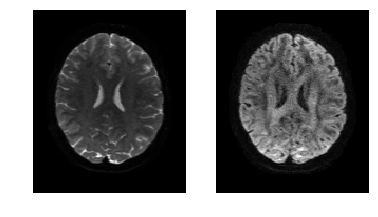

In [6]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [85]:
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask = np.zeros(binarymask.shape)
ccmask[20:50,55:85,38:39] = 1

In [98]:
ccseeds = seeds_from_mask(ccmask)

In [86]:
ccmask, options = nrrd.read('100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask)

Slicer/UKF Data

## Diffusion Tensor Imaging

compute fractional anisotropy and select seeds_count seeds per voxel with FA > 0.3

In [96]:
import dipy.reconst.dti as dti
dti_wls = dti.TensorModel(gtab)
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
fit_wls = dti_wls.fit(dwi)
FA = fit_wls.fa
seeds = random_seeds_from_mask(FA > 0.5, seeds_count=1)

In [99]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)
runtime = time.time() - start_time

In [100]:
GFA = dtipeaks.gfa
print('Runtime ' + str(runtime) + 's / GFA.shape (%d, %d, %d)' % GFA.shape)

Runtime 1050.7868649959564s / GFA.shape (145, 174, 145)


In [349]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, np.identity(4), step_size=.1)
streamlines_generator = LocalTracking(dtipeaks, classifier, seeds, np.identity(4), step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

In [350]:
dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=40)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Constrained Spherical Deconvolution

Use in case of b = 2,500 – 3,000 s/mm² data

In [90]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csd_peaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

(array([0.00123238, 0.00030619, 0.00030619]), 3265.4858)
0.24845135916813632
Runtime 596.3909592628479 s / GFA.shape (145, 174, 145)


In [93]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .25)
streamlines_generator = LocalTracking(csd_peaks, classifier, ccseeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [95]:
dwi_tools.visStreamlines(streamlines_filtered,t1)


/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### Store intermediate data

In [ ]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_filtered)
np.save(pTrainInput + "_sl.npy",streamlines)
np.save(pTrainInput + "_seeds.npy",seeds)

# Generate Training data

prepare training data for fibre direction network

In [146]:
dwi_B0normalized = dwi / np.max(dwi[:, :, :, gtab.b0s_mask])
dwi_B0normalized = dwi_B0normalized[:, :, :, ~gtab.b0s_mask]

In [151]:
noX = 8
noY = 8
noZ = 8
coordinateScaling = 0.5

In [ ]:
import importlib
importlib.reload(dwi_tools)
streamlines_filtered = np.asarray(np.load(pTrainInput + "_sl_filt.npy"))
#np.random.shuffle(streamlines_filtered)
import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper
start_time = time.time()
train_DWI,train_curPosition, train_LikelyFibreDirections, train_NextFibreDirection = dwi_tools.generatePredictionNetworkTrainingDataFromStreamlines(streamlines_filtered, dwi_B0normalized, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossings)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [156]:
with h5py.File(pTrainData_fibrePrediction,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_curPosition)   
    f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_NextFibreDirection)   

## Training

In [157]:
noGPUs = 3
batch_size = 2**8
batch_size -= batch_size % noGPUs # make batch size divisible by no. of GPUs
epochs = 50

In [158]:
f = h5py.File(pTrainData_fibrePrediction, "r")
train_DWI = np.array(f["train_DWI"].value)
train_lastDirection = np.array(f["train_curPosition"].value)
train_LikelyFibreDirections = np.array(f["train_LikelyFibreDirections"].value)
train_NextFibreDirection = np.array(f["train_NextFibreDirection"].value)
f.close()
#train_lastDirection = np.expand_dims(train_lastDirection, axis=1)

### data normalization

In [159]:
#train_LikelyFibreDirections = (train_LikelyFibreDirections + 1) / 2
#train_lastDirection = (train_lastDirection + 1) / 2
#train_DWI = nn_helper.normalizeDWI(train_DWI)
train_lastDirection_unit = nn_helper.normalizeStreamlineOrientation(train_lastDirection)

/home/nico/Code/deepFibreTracking/src/nn_helper.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return smpls
/home/nico/Code/deepFibreTracking/src/nn_helper.py:25: RuntimeWarning: invalid value encountered in true_divide
  return smpls


### MSD Network

In [160]:
from keras.layers.advanced_activations import LeakyReLU

import importlib
importlib.reload(nn_helper)

<module 'src.nn_helper' from '/home/nico/Code/deepFibreTracking/src/nn_helper.py'>

In [ ]:
from keras.callbacks import TensorBoard
msd_simple = nn_helper.get_msd_simplified_trackerNetwork(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
msd_simple.fit([train_DWI], [train_lastDirection_unit], batch_size=batch_size, epochs=epochs, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
from keras.callbacks import TensorBoard
msd_tracker = nn_helper.get_msd_trackerNetwork(activation_function = LeakyReLU(), inputShape1=(noX, noY, noZ, 288),inputShape2=(1,3),depth = 3, noCrossings = noCrossings, noGPUs=noGPUs)
msd_tracker.fit([train_DWI,train_lastDirection], [train_LikelyFibreDirections,train_NextFibreDirection], batch_size=batch_size, epochs=epochs, verbose=1,validation_split=0.2)

### UNET

In [ ]:
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_advancedTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 288),inputShapeStreamline=(1,3),depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI, train_lastDirection], [train_NextFibreDirection], batch_size=batch_size, epochs=epochs, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_NextFibreDirection], batch_size=batch_size, epochs=1000, verbose=1,validation_split=0.2, callbacks=[])

Train on 18849 samples, validate on 4713 samples
Epoch 1/1000
18849/18849 [==============================] - 44s 2ms/step - loss: -0.1241 - val_loss: -0.1338
Epoch 2/1000
18849/18849 [==============================] - 20s 1ms/step - loss: -0.1276 - val_loss: -0.0903
Epoch 3/1000
18849/18849 [==============================] - 20s 1ms/step - loss: -0.1219 - val_loss: -0.0873
Epoch 4/1000
18849/18849 [==============================] - 21s 1ms/step - loss: -0.1307 - val_loss: -0.1239
Epoch 5/1000
18849/18849 [==============================] - 21s 1ms/step - loss: -0.1229 - val_loss: -0.1550
Epoch 6/1000
18849/18849 [==============================] - 21s 1ms/step - loss: -0.1208 - val_loss: -0.1252
Epoch 7/1000
18849/18849 [==============================] - 20s 1ms/step - loss: -0.1281 - val_loss: -0.1270
Epoch 8/1000
18849/18849 [==============================] - 20s 1ms/step - loss: -0.1442 - val_loss: -0.0623
Epoch 9/1000
18849/18849 [==============================] - 20s 1ms/step - loss

## Tracking

In [424]:
np.prod((8,8,8))

512

In [202]:
import src.tracking as tracking
importlib.reload(tracking)

<module 'src.tracking' from '/home/nico/Code/deepFibreTracking/src/tracking.py'>

## MSD/Simple Network

In [ ]:
start_time = time.time()
streamlines_msd_simple = tracking.applySimpleTrackerNetwork(seeds=[ccseeds[1]],data=dwi_B0normalized, model=msd_simple, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [191]:
streamlines_msd_simple[1,5,:]

array([69.73501964, 67.73650932, 61.85734136])

In [192]:
streamlines_msd_simple[1,6,:]

array([69.66997141, 67.66963936, 61.82132558])

In [204]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visStreamlines(streamlines_msd_simple,t1, vol_slice_idx = 73)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### MSD/Advanced Tracking Network

In [415]:
start_time = time.time()
streamlines_msd_adv = tracking.applyTrackerNetwork(seeds=ccseeds,data=dwi, model=msd, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

/home/nico/Code/deepFibreTracking/src/nn_helper.py:29: RuntimeWarning: invalid value encountered in true_divide
  dwi /= np.max(dwi)


Runtime 788.2131440639496 s 


In [416]:
dwi_tools.visStreamlines(streamlines_msd_adv,t1, vol_slice_idx = 73)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


### UNET/Advanced Tracking Network

In [ ]:
start_time = time.time()
streamlines = tracking.applyTrackerNetwork(seeds=ccseeds,data=dwi, model=unet_tracker, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
dwi_tools.visStreamlines(streamlines,t1, vol_slice_idx = 73)